# Run this notebook to generate the data for the non-spatial figures

In [2]:
%reload_ext autoreload
%autoreload 2

# Imports and settings

In [3]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

from NoDiffusionSolver import *
from NoDiffusionStatistics import make_steady_state_distributions, make_cctd_functions, division_rate, compute_mean_ages

# Set global font size parameters
plt.rcParams['savefig.dpi'] = 600  # Set global DPI for saved figures
plt.rcParams['figure.dpi'] = 300  # Set DPI for on-screen display 
plt.rcParams.update({
    'axes.labelsize': 16,         # Label font size
    'xtick.labelsize': 14,        # x-axis tick label font size
    'ytick.labelsize': 14,        # y-axis tick label font size
    'legend.fontsize': 11,        # Legend font size
    'axes.titlesize' : 16
})
%config InlineBackend.figure_format = 'png'  # or 'retina' 

# Solution settings
case_mapping = {# death_case, birth_case : case_num
        (1, 1): 1,
        (1, 2): 2,
        (1, 3): 3,
        (2, 3): 4,
        (3, 3): 5,
        (2, 1): 6
    }

# Helper functions

In [4]:
def save_case(case_num, case_data, outdir="saved_cases"):
    os.makedirs(outdir, exist_ok=True)
    pkl_path = os.path.join(outdir, f"case{case_num}.pkl")
    with open(pkl_path, "wb") as f:
        pickle.dump(case_data, f)

def load_case(case_num, outdir="saved_cases"):
    pkl_path = os.path.join(outdir, f"case{case_num}.pkl")
    with open(pkl_path, "rb") as f:
        return pickle.load(f)

def compute_death_rate(a, P, death_case, params):

    mu0 = params['mu0']
    gamma = params['gamma']
    alpha = params['alpha']

    if death_case == 1:
        return mu0 * np.ones_like(a)
    elif death_case == 2:
        return mu0 * P * np.ones_like(a)
    elif death_case == 3:
        return (mu0 - gamma * a * np.exp(-alpha * a)) * P

def compute_birth_rate(a, P, birth_case, params):

    b0 = params['b0']
    alpha = params['alpha']

    if birth_case == 1:
        return b0 * (1 - P) * np.ones_like(a)
    elif birth_case == 2:
        return b0 * np.exp(-alpha * a) * (1 - P)
    elif birth_case == 3:
        return b0 * a * np.exp(-alpha * a) * (1 - P)

def compute_integrals(a, u, da, params):

    alpha = params['alpha']
    
    P = simpson(u, dx=da)  # Total population
    C = simpson(np.exp(-alpha * a) * u, dx=da)  # Exponential-weighted
    D = simpson(a * np.exp(-alpha * a) * u, dx=da)  # Age-weighted
    return P, C, D



In [5]:
def plot_solution_suite(params, a_list, u_list, u0_list, P_list, save_every, birth_case, case_num, 
                        make_steady_state_distributions, make_cctd_functions, division_rate):
    """
    In a 2x3 grid: heatmap, SSD, CCTD, Birth BC, P(t), last box is empty
    """
    # Get initial condition
    a_initial = a_list[0]  # Age grid at t=0
    u_initial = u_list[0]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    ax = axes.flatten()
    
    # --- HEATMAP ---
    if save_every is None:
            save_every = max(1, int(1/params['da']))
    n_saved = len(a_list)
    
    plot_stride = 10
    time_indices = np.arange(0, n_saved, plot_stride)
    time_points = time_indices * (params['da'] * save_every)

    age_points = np.arange(0, params['a_max'] + params['T'] + params['da'], params['da'])
    max_possible_age = params['a_max'] + params['T']
    heatmap = np.full((len(age_points), len(time_points)), np.nan)
    
    for idx, t_idx in enumerate(time_indices):
        current_ages = a_list[t_idx]
        current_u = u_list[t_idx]
        age_indices = np.searchsorted(age_points, current_ages)
        valid = age_indices < len(age_points)
        heatmap[age_indices[valid], idx] = current_u[valid]

    pcm = ax[0].pcolormesh(time_points, age_points, heatmap,
                shading='auto',
                cmap='plasma',
                vmin=0,
                vmax=max(u_list[-1]) * 1.1 
            )
    fig.colorbar(pcm, ax=ax[0], label='Density u(a,t)')
    ax[0].set_title(r'Heatmap of $u(a, t)$')
    ax[0].set_xlabel('Time (t)')
    ax[0].set_ylabel('Age (a)')
    ax[0].set_ylim(0, max_possible_age)
    ax[0].grid(True, linestyle=':', linewidth=0.4, alpha=0.8)

    # --- FINAL AGE DIST + SSD ---
    final_u = u_list[-1]
    final_ages = a_list[-1]
    P_bar = P_list[-1]

    ssd_dict = make_steady_state_distributions(
        beta=params['b0'], alpha=params['alpha'], mu=params['mu0'],
        gamma=params['gamma'], P_bar=P_bar
    )
    ssd_fn = ssd_dict[case_num]

    ax[1].plot(final_ages, final_u, label=r"Numerical $u(a, T)$", linewidth=4, color='tab:green')
    ax[1].plot(final_ages, ssd_fn(final_ages), '--', label="Exact SSD $F(a)$", linewidth=2, color='black')
    ax[1].set_title('Steady-state distribution')
    ax[1].set_xlabel('Age (a)')
    ax[1].set_ylabel('Density')
    # ax[1].set_yscale('log')
    ax[1].legend()
    ax[1].grid(alpha=0.3)


    # --- CCTD ---
    cctd_dict = make_cctd_functions(
        beta=params['b0'], alpha=params['alpha'], mu=params['mu0'],
        gamma=params['gamma'], P_bar=P_bar
    )
    cctd_fn = cctd_dict[case_num]
    cctd_ages = final_ages
    numerical_cctd = division_rate(params['b0'], params['alpha'], cctd_ages, P_bar, birth_case) * final_u
    analytical_cctd = cctd_fn(cctd_ages)
    numerical_cctd /= simpson(numerical_cctd, cctd_ages) # Normalise
    analytical_cctd /= simpson(analytical_cctd, cctd_ages) # Normalise

    ax[2].plot(cctd_ages, numerical_cctd, label='Numerical CCTD', linewidth=4, color='tab:purple')
    ax[2].plot(cctd_ages, analytical_cctd, '--', label='Exact CCTD', linewidth=2, color='black')
    ax[2].set_title('Cell cycle time distribution')
    ax[2].set_xlabel('Age (a)')
    ax[2].set_ylabel('CCTD')
    # ax[2].set_yscale('log')
    ax[2].legend()
    ax[2].grid(alpha=0.3)

    # --- BIRTH BC ---
    time_bc = np.linspace(0, params['T'] + 1e-8, len(a_list))
    ax[3].plot(time_bc, u0_list, color='tab:orange', linewidth=2)
    ax[3].set_title(r'$u(0, t)$, boundary condition')
    ax[3].set_xlabel('Time (t)')
    ax[3].set_ylabel(r'$u(0, t)$')
    ax[3].grid(alpha=0.2)

    # --- P(t) ---
    time_P = np.linspace(0, params['T'] + 1e-8, len(P_list))
    ax[4].plot(time_P, P_list, 'b-', linewidth=2)
    P0 = simpson(u_initial, a_initial)
    ax[4].axhline(P0, color='r', linestyle='--', alpha=0.6, label=f'Initial P = {P0:.2f}')
    ax[4].set_title('Total population P(t)')
    ax[4].set_xlabel('Time (t)')
    ax[4].set_ylabel('P(t)')
    ax[4].legend()
    ax[4].grid(alpha=0.3)

    # --- BLANK PANEL ---
    ax[5].axis('off')

    plt.tight_layout()
    plt.show()


[Non-spatial] Steady state detected at t=361.900
[Non-spatial] Continuing until t=1000.000
[Non-spatial] Complete at t=1000.000
Final population: (case 1,1): P=0.815, C=0.576, D=16.923
Mean division age: 20.788, Mean population age: 41.571


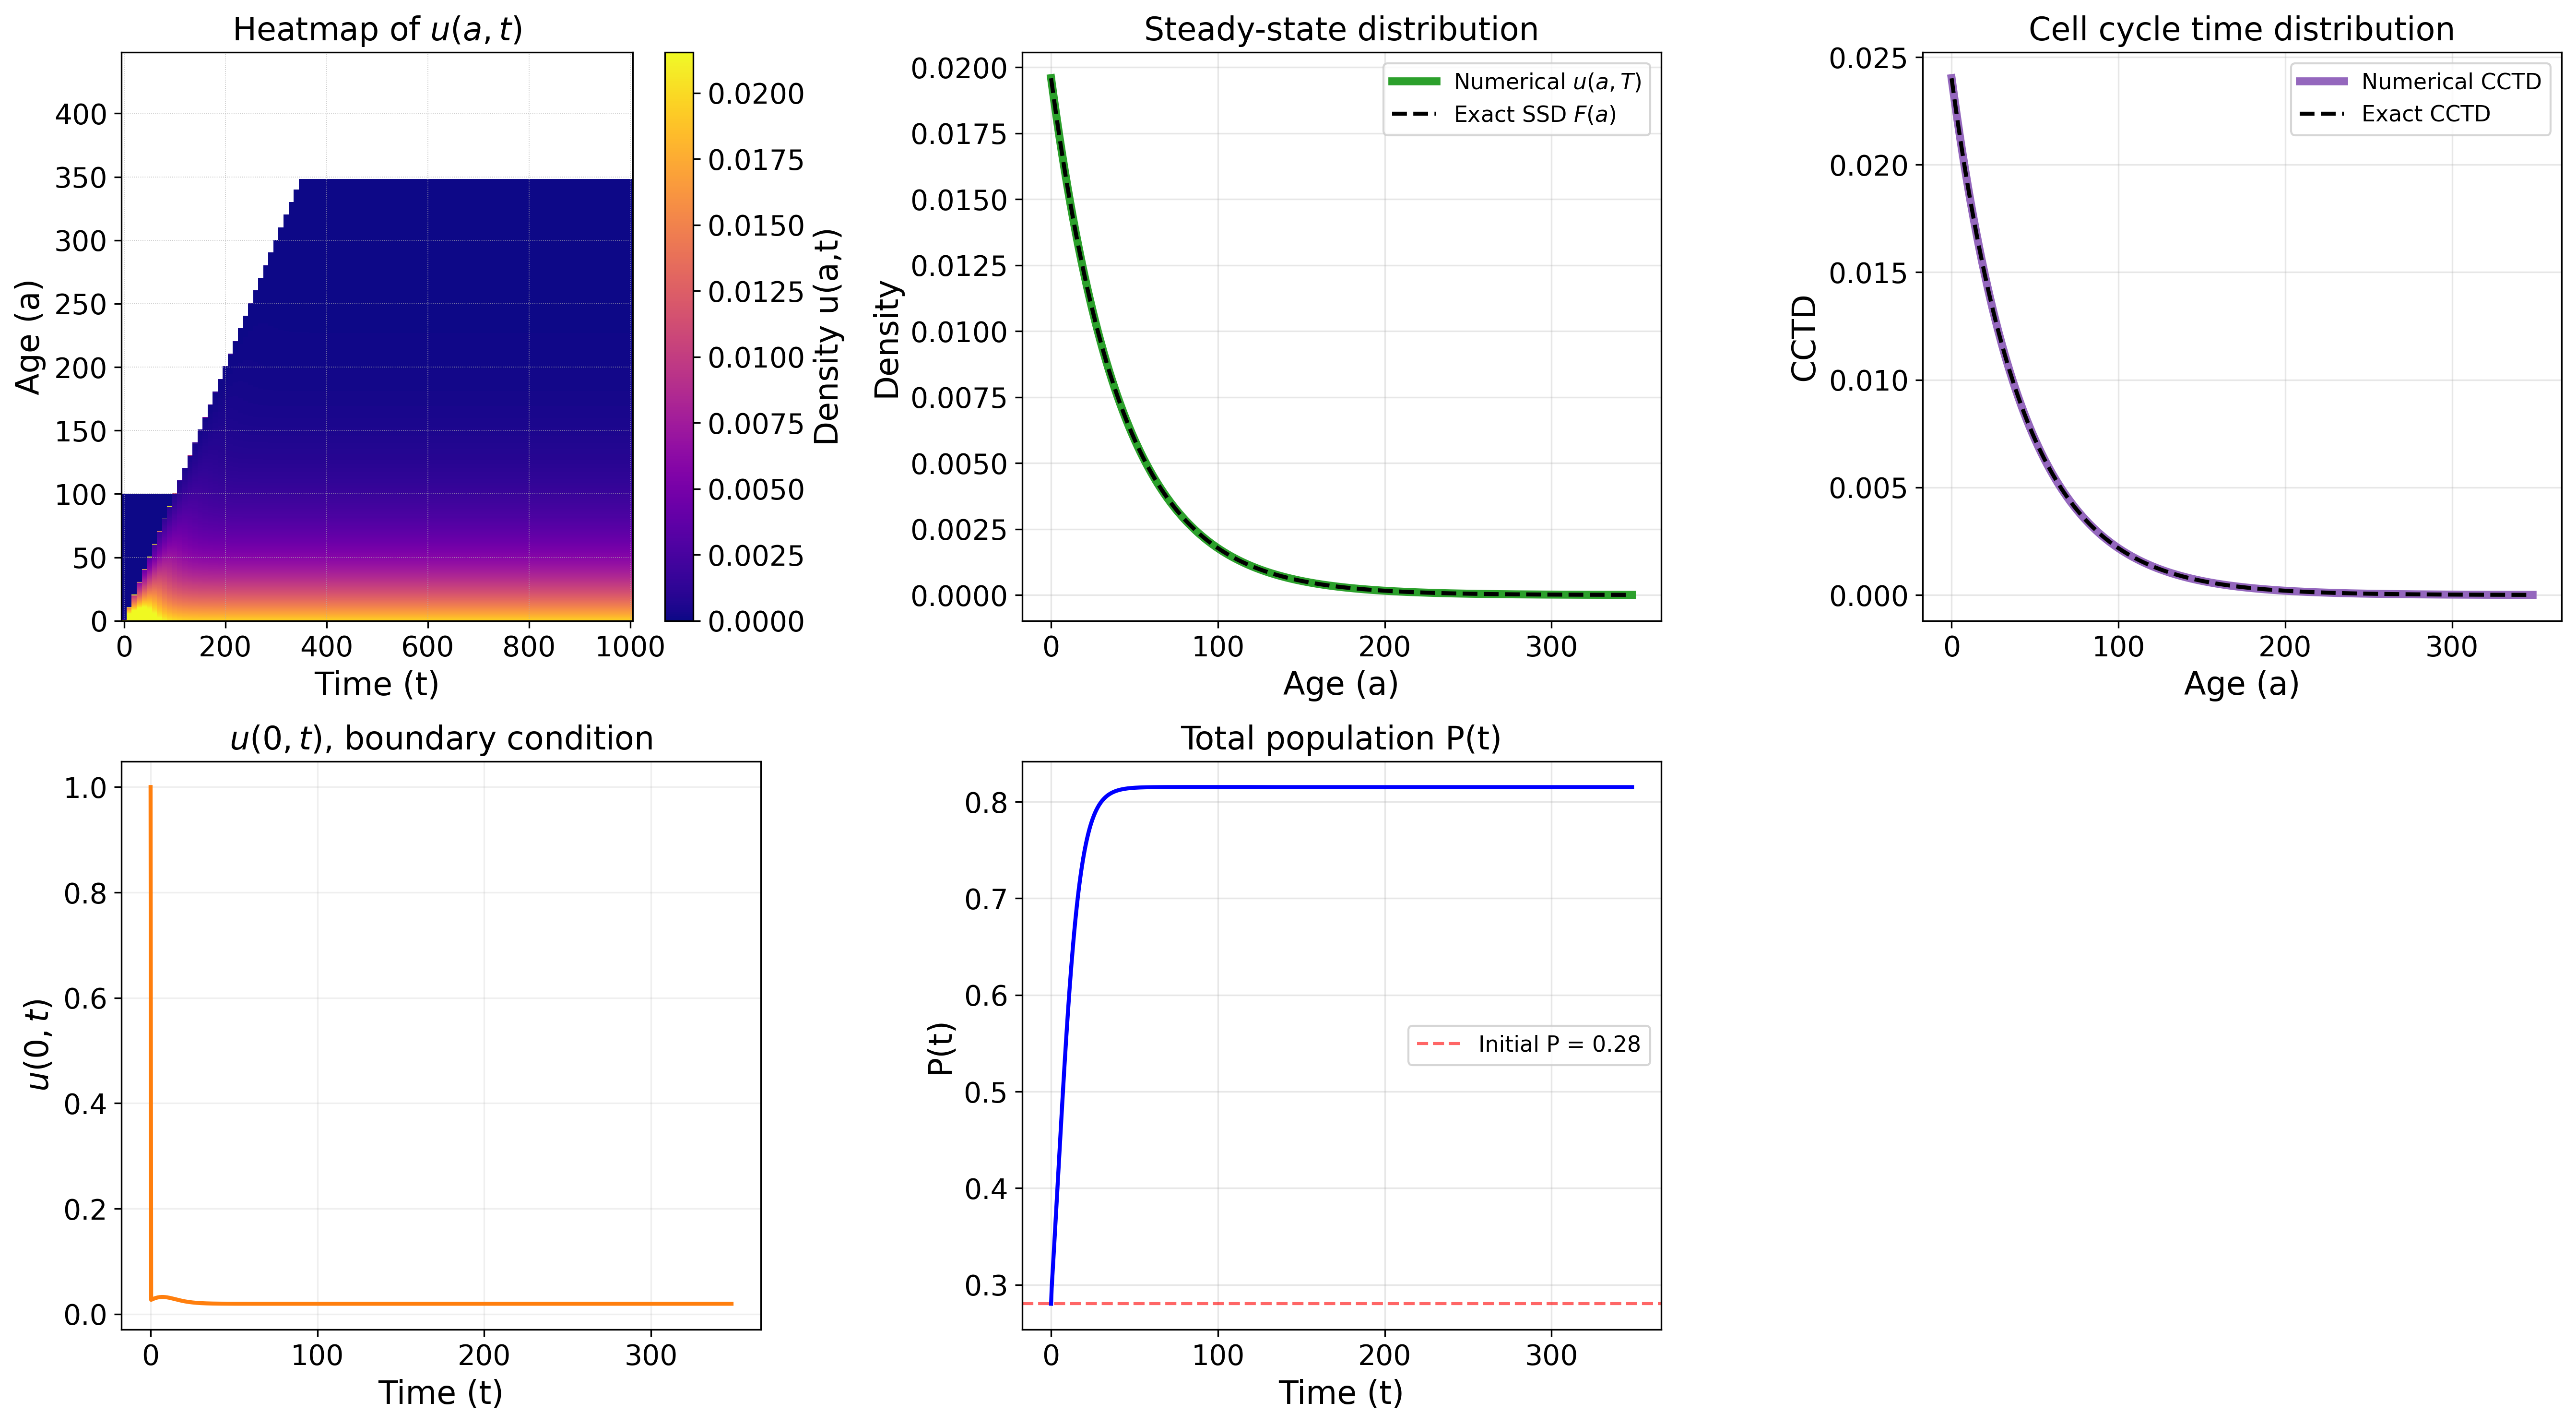

In [ ]:
# Case 1
birth_case = 1
death_case = 1
case_num = case_mapping[(death_case, birth_case)]
save_every = 100

params = { 'alpha': 0.01, 'mu0': 0.012, 'b0': 0.065, 'a_max': 100, 'da': 1e-2, 'T': 1000}
params['gamma'] = 1 # unused in this case

# Run model until steady state
model = NoDiffusionSolver(**params, birth_case=birth_case, death_case=death_case)
a_list, u_list, u0_list, P_list, C_list, D_list = model.solve(
        save_every=save_every,
        steady_state_tol=1e-6, 
        extend_after_ss=100.0,
    )
print(f"Final population: (case {birth_case},{death_case}): P={P_list[-1]:.3f}, C={C_list[-1]:.3f}, D={D_list[-1]:.3f}")

# Compute population statistics
beta=params['b0']
alpha=params['alpha']
mu=params['mu0']
gamma=params['gamma']
params['T'] = a_list[-1][-1]
T = params['T']

ages = model.age_grid[:len(u_list)]
mask = ages <= T
ages_plot = a_list[-1] 

# Extract population metrics
P_bar = float(P_list[-1])
mean_div_age, mean_pop_age = compute_mean_ages(beta, alpha, gamma, mu, P_bar, ages_plot, case_num, return_values=True)
print(f"Mean division age: {mean_div_age:.3f}, Mean population age: {mean_pop_age:.3f}")

# Plot
plot_solution_suite(params, a_list, u_list, u0_list, P_list, save_every, birth_case, case_num, 
                        make_steady_state_distributions, make_cctd_functions, division_rate)

# Create time list based on save_every
t_list = np.arange(len(P_list)) * params['da'] * save_every

case_data = {
    "a_list": a_list,
    "u_list": u_list,
    "u0_list": u0_list,
    "P_list": P_list,
    "C_list": C_list,
    "D_list": D_list,
    "t_list": t_list,  
    "a_final": a_list[-1],
    "u_final": u_list[-1],
    "P_bar": P_list[-1],
    "C_bar": C_list[-1],
    "D_bar": D_list[-1],
    "params": params,
    "case_num": case_num,
    "birth_case": birth_case,
    "death_case": death_case,
    "mean_div_age": mean_div_age,
    "mean_pop_age": mean_pop_age,
    "t_ss": model.t_ss,  
    "steady_state_tol": 1e-6, 
    "extend_after_ss": 100.0, 
    "save_every": save_every,  
}

save_case(case_num, case_data, outdir="saved_cases_no_diffusion")

[Non-spatial] Steady state detected at t=451.900
[Non-spatial] Continuing until t=1000.000
[Non-spatial] Complete at t=1000.000
Final population: (case 1,2): P=0.844, C=0.565, D=18.677
Mean division age: 24.638, Mean population age: 49.278


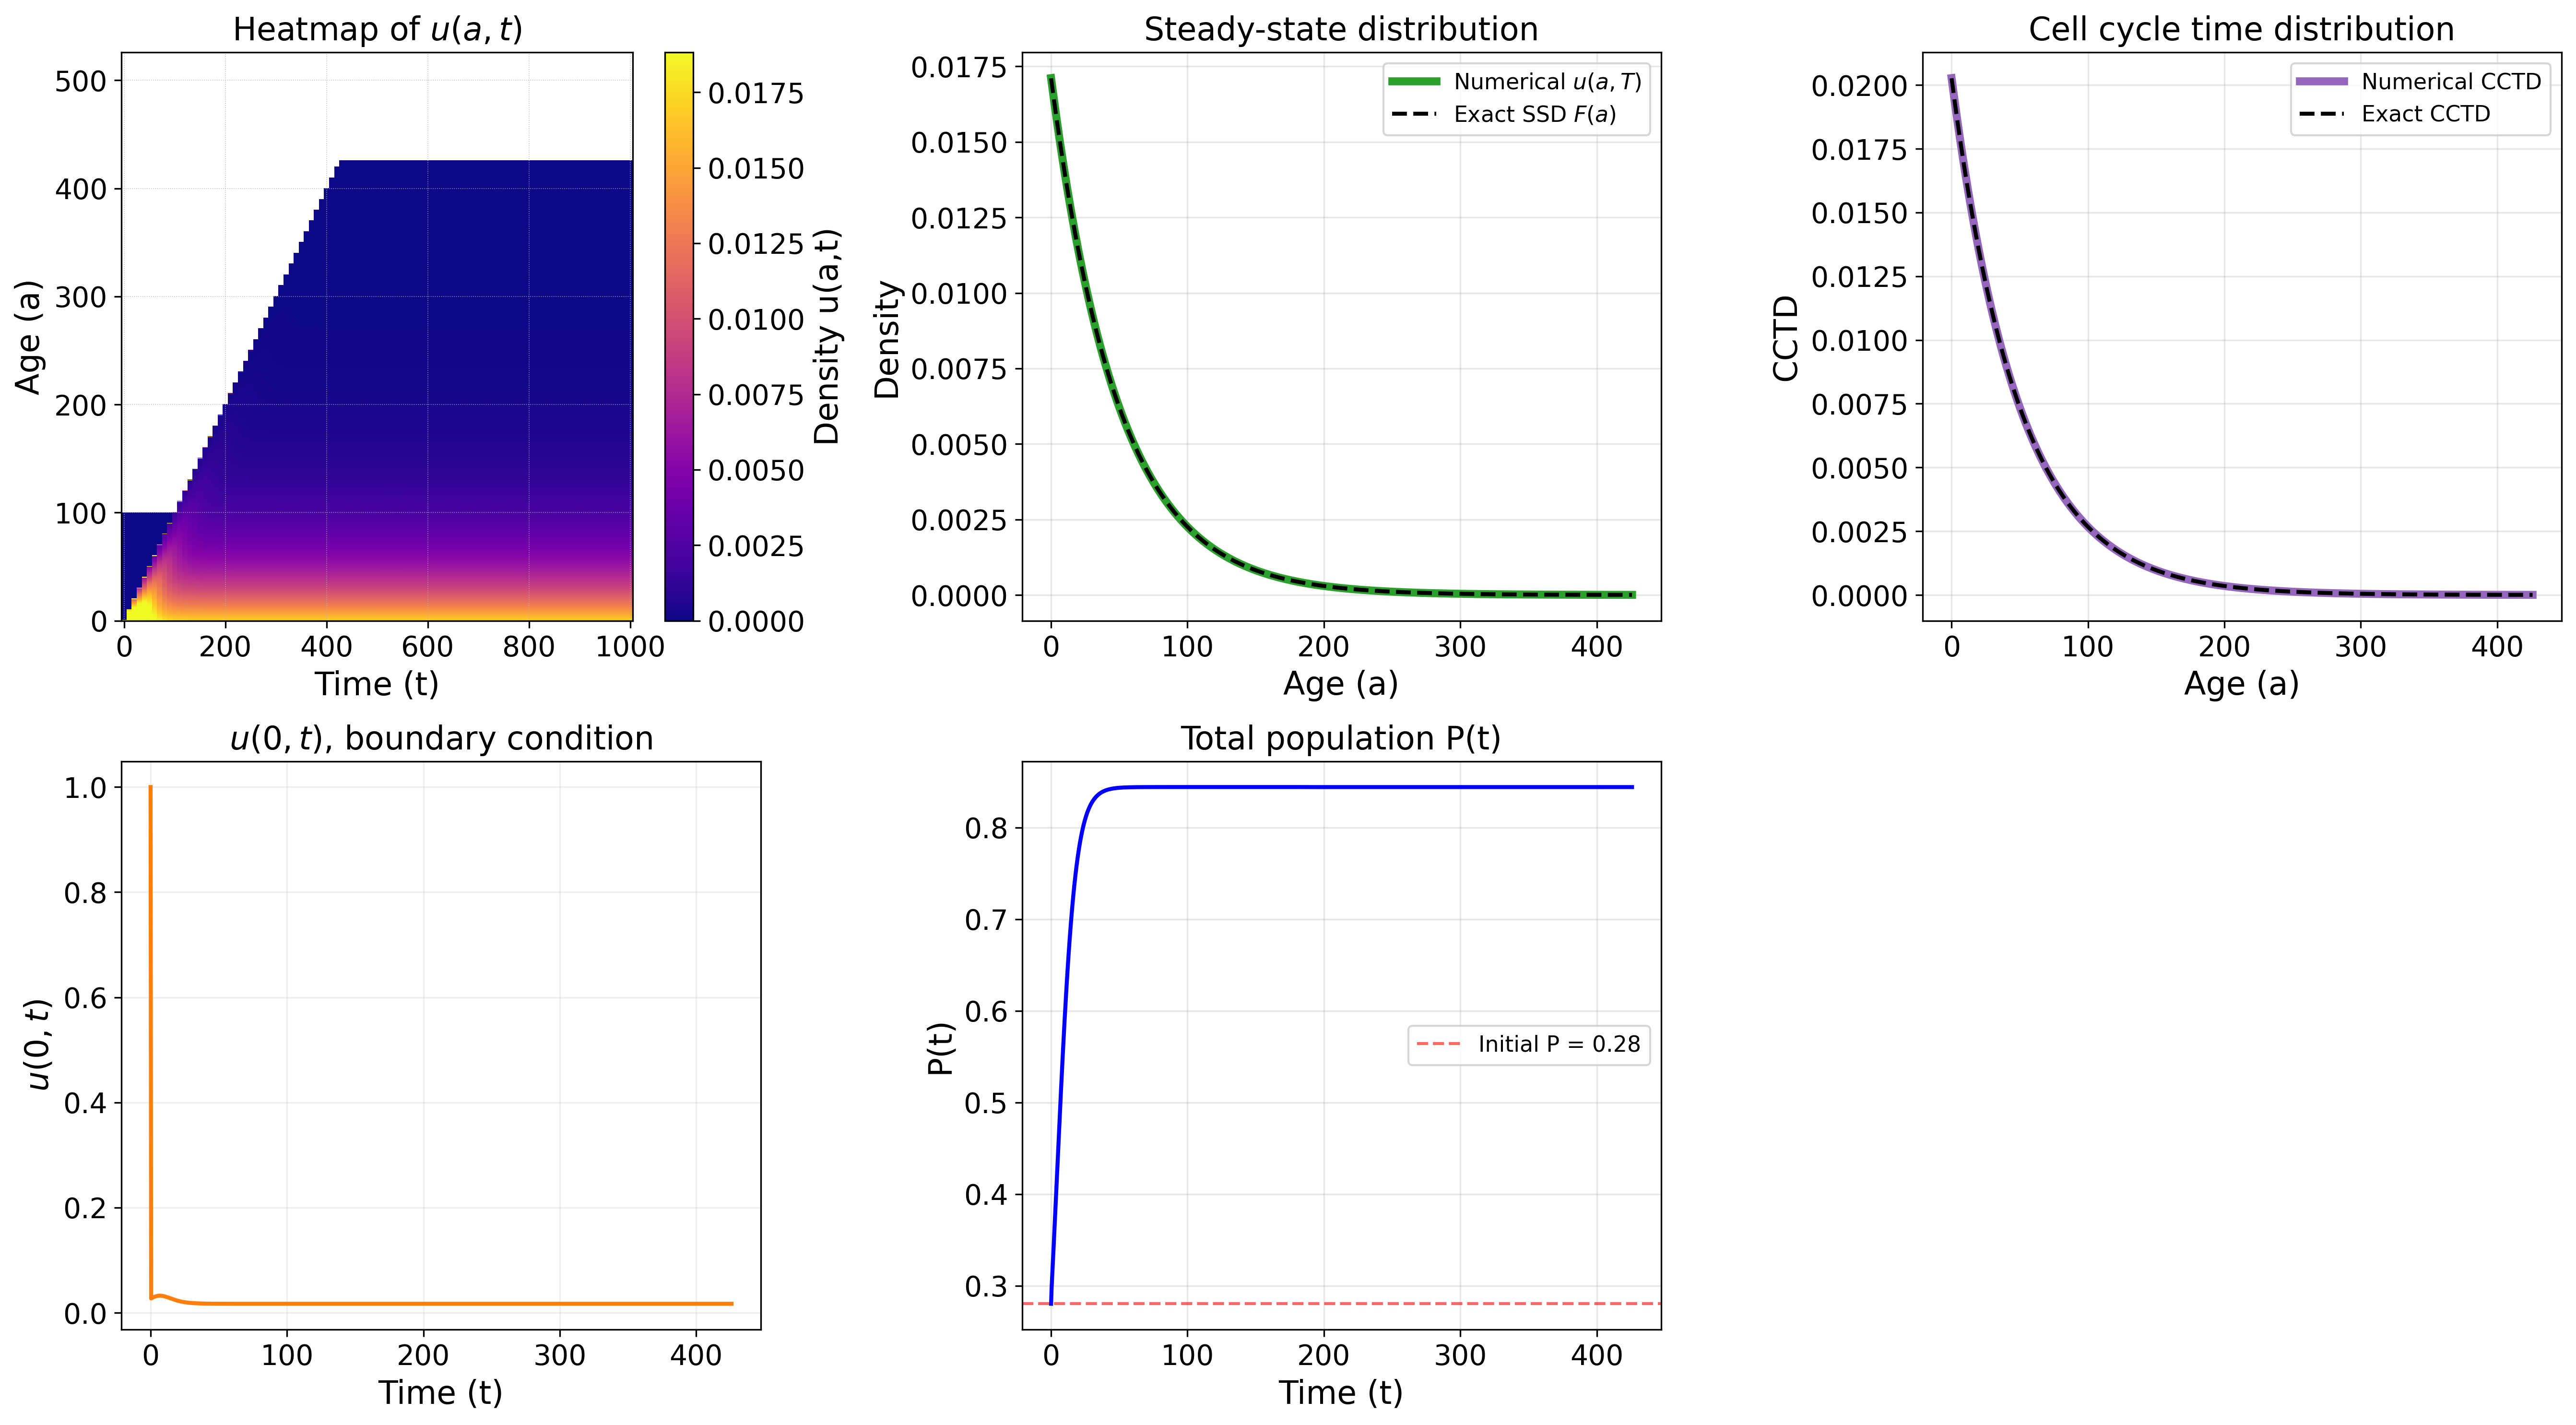

In [ ]:
# Case 1b
birth_case = 1
death_case = 2
case_num = case_mapping[(death_case, birth_case)]
save_every = 100

params = { 'alpha': 0.01, 'mu0': 0.012, 'b0': 0.065, 'a_max': 100, 'da': 1e-2, 'T': 1000}
params['gamma'] = 1 # unused in this case

# Run model until steady state
model = NoDiffusionSolver(**params, birth_case=birth_case, death_case=death_case)
a_list, u_list, u0_list, P_list, C_list, D_list = model.solve(
        save_every=save_every,
        steady_state_tol=1e-6, 
        extend_after_ss=100.0,
    )
print(f"Final population: (case {birth_case},{death_case}): P={P_list[-1]:.3f}, C={C_list[-1]:.3f}, D={D_list[-1]:.3f}")

# Compute population statistics
beta=params['b0']
alpha=params['alpha']
mu=params['mu0']
gamma=params['gamma']
params['T'] = a_list[-1][-1]
T = params['T']

ages = model.age_grid[:len(u_list)]
mask = ages <= T
ages_plot = a_list[-1] 

# Extract population metrics
P_bar = float(P_list[-1])
mean_div_age, mean_pop_age = compute_mean_ages(beta, alpha, gamma, mu, P_bar, ages_plot, case_num, return_values=True)
print(f"Mean division age: {mean_div_age:.3f}, Mean population age: {mean_pop_age:.3f}")

# Plot
plot_solution_suite(params, a_list, u_list, u0_list, P_list, save_every, birth_case, case_num, 
                        make_steady_state_distributions, make_cctd_functions, division_rate)

# Create time list based on save_every
t_list = np.arange(len(P_list)) * params['da'] * save_every

case_data = {
    "a_list": a_list,
    "u_list": u_list,
    "u0_list": u0_list,
    "P_list": P_list,
    "C_list": C_list,
    "D_list": D_list,
    "t_list": t_list,  
    "a_final": a_list[-1],
    "u_final": u_list[-1],
    "P_bar": P_list[-1],
    "C_bar": C_list[-1],
    "D_bar": D_list[-1],
    "params": params,
    "case_num": case_num,
    "birth_case": birth_case,
    "death_case": death_case,
    "mean_div_age": mean_div_age,
    "mean_pop_age": mean_pop_age,
    "t_ss": model.t_ss,  
    "steady_state_tol": 1e-6, 
    "extend_after_ss": 100.0, 
    "save_every": save_every,  
}

save_case(case_num, case_data, outdir="saved_cases_no_diffusion")

[Non-spatial] Steady state detected at t=596.300
[Non-spatial] Continuing until t=1000.000
[Non-spatial] Complete at t=1000.000
Final population: (case 2,1): P=0.726, C=0.488, D=15.235
Mean division age: 15.604, Mean population age: 51.953


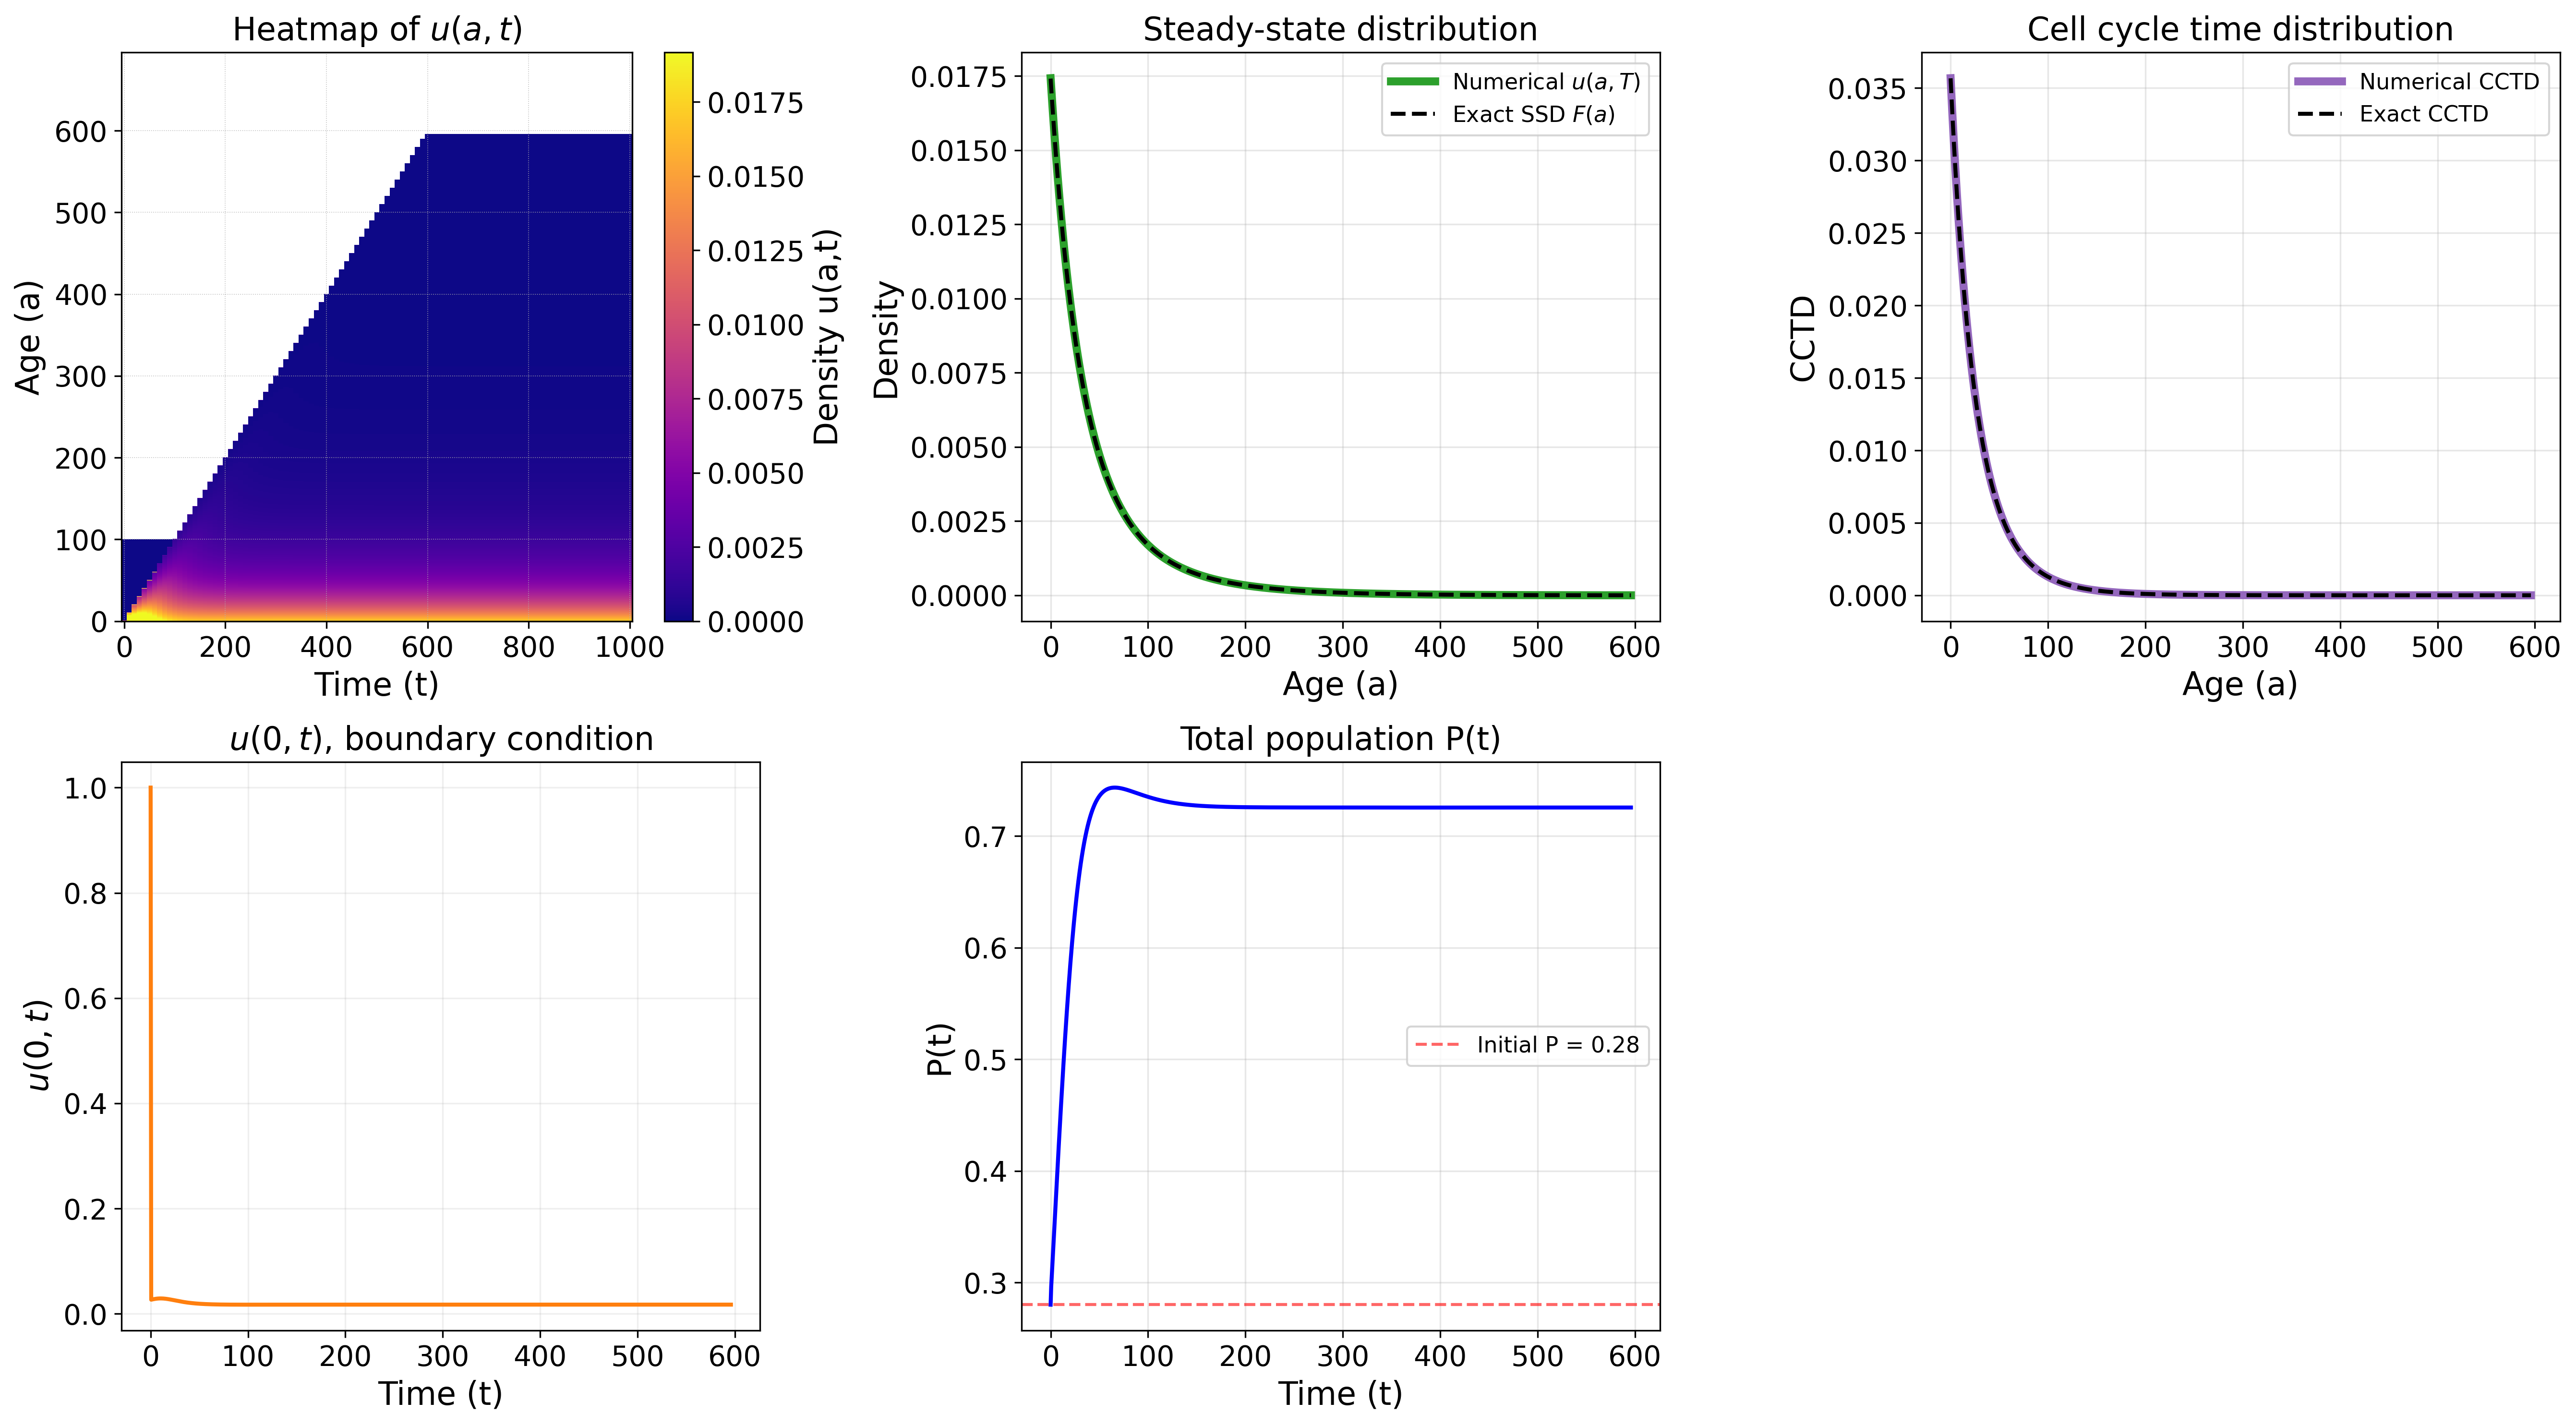

In [ ]:
# Case 2
birth_case = 2
death_case = 1
case_num = case_mapping[(death_case, birth_case)]
save_every = 100

params = { 'alpha': 0.01, 'mu0': 0.012, 'b0': 0.065, 'a_max': 100, 'da': 1e-2, 'T': 1000}
params['gamma'] = 1 # unused in this case

# Run model until steady state
model = NoDiffusionSolver(**params, birth_case=birth_case, death_case=death_case)
a_list, u_list, u0_list, P_list, C_list, D_list = model.solve(
        save_every=save_every,
        steady_state_tol=1e-6, 
        extend_after_ss=100.0,
    )
print(f"Final population: (case {birth_case},{death_case}): P={P_list[-1]:.3f}, C={C_list[-1]:.3f}, D={D_list[-1]:.3f}")

# Compute population statistics
beta=params['b0']
alpha=params['alpha']
mu=params['mu0']
gamma=params['gamma']
params['T'] = a_list[-1][-1]
T = params['T']

ages = model.age_grid[:len(u_list)]
mask = ages <= T
ages_plot = a_list[-1] 

# Extract population metrics
P_bar = float(P_list[-1])
mean_div_age, mean_pop_age = compute_mean_ages(beta, alpha, gamma, mu, P_bar, ages_plot, case_num, return_values=True)
print(f"Mean division age: {mean_div_age:.3f}, Mean population age: {mean_pop_age:.3f}")

# Plot
plot_solution_suite(params, a_list, u_list, u0_list, P_list, save_every, birth_case, case_num, 
                        make_steady_state_distributions, make_cctd_functions, division_rate)

# Create time list based on save_every
t_list = np.arange(len(P_list)) * params['da'] * save_every

case_data = {
    "a_list": a_list,
    "u_list": u_list,
    "u0_list": u0_list,
    "P_list": P_list,
    "C_list": C_list,
    "D_list": D_list,
    "t_list": t_list,  
    "a_final": a_list[-1],
    "u_final": u_list[-1],
    "P_bar": P_list[-1],
    "C_bar": C_list[-1],
    "D_bar": D_list[-1],
    "params": params,
    "case_num": case_num,
    "birth_case": birth_case,
    "death_case": death_case,
    "mean_div_age": mean_div_age,
    "mean_pop_age": mean_pop_age,
    "t_ss": model.t_ss,  
    "steady_state_tol": 1e-6, 
    "extend_after_ss": 100.0, 
    "save_every": save_every,  
}

save_case(case_num, case_data, outdir="saved_cases_no_diffusion")

[Non-spatial] Steady state detected at t=350.600
[Non-spatial] Continuing until t=1000.000
[Non-spatial] Complete at t=1000.000
Final population: (case 3,1): P=0.991, C=0.735, D=19.388
Mean division age: 24.371, Mean population age: 34.016


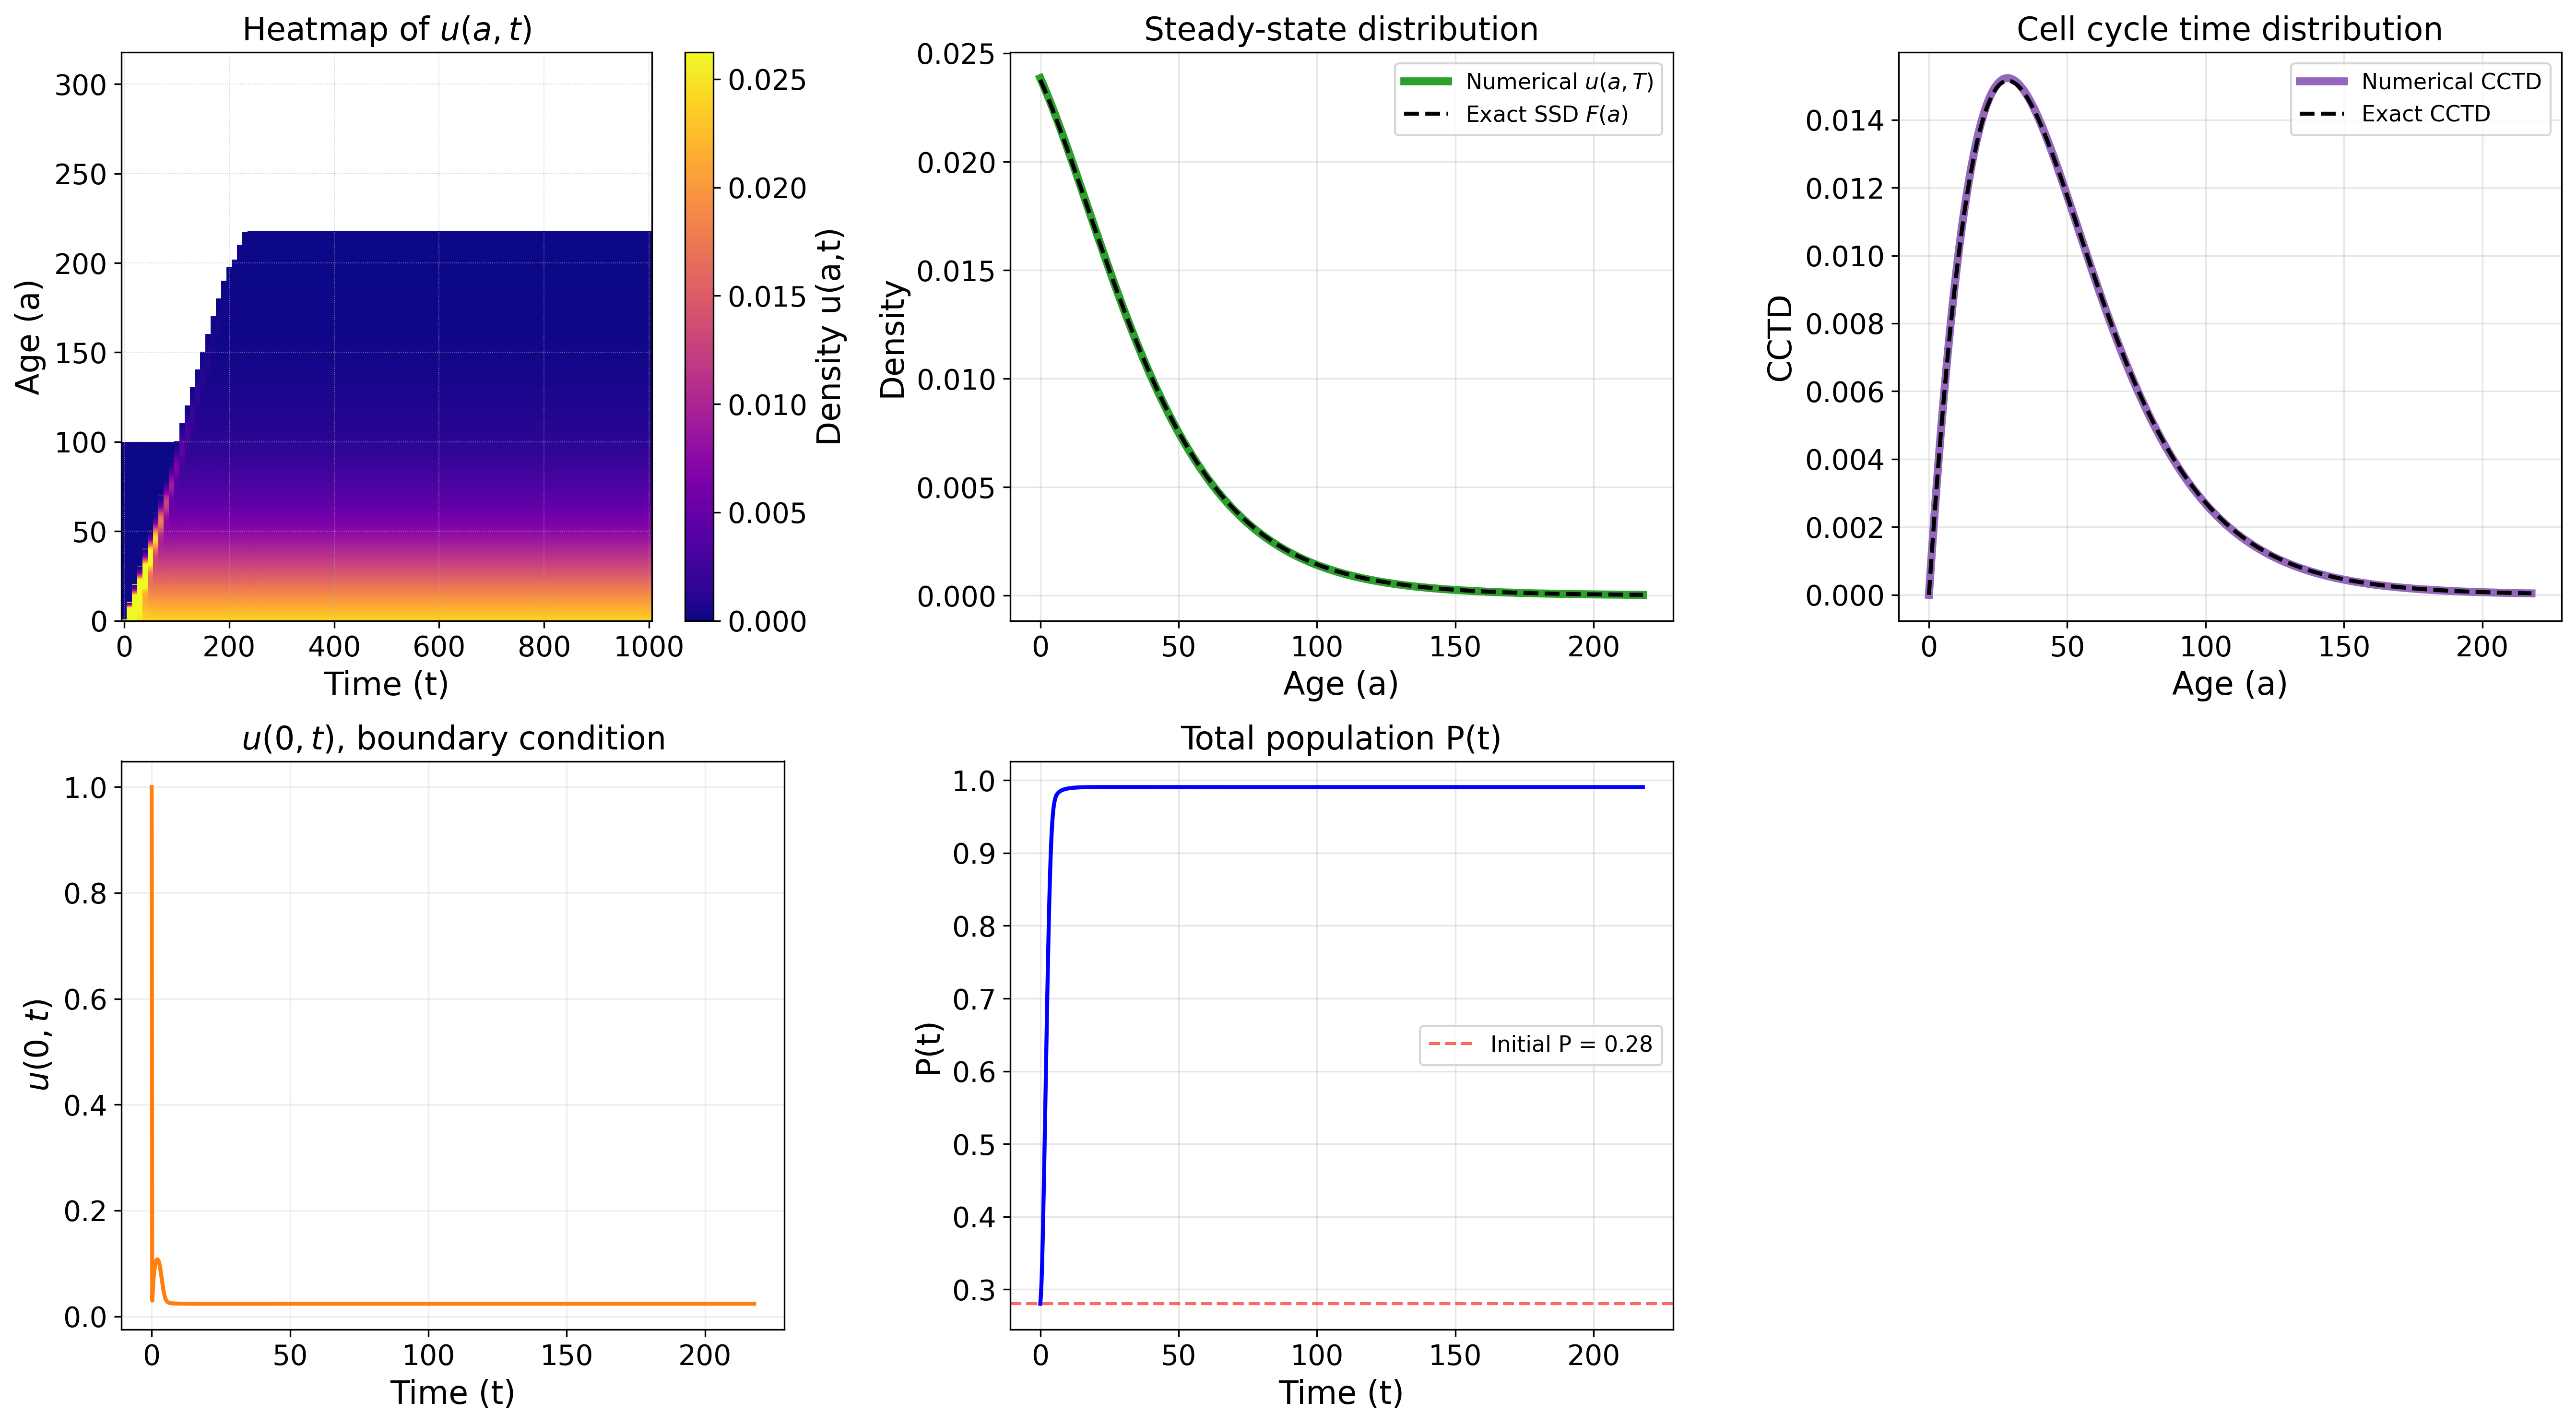

In [ ]:
# Case 3
birth_case = 3
death_case = 1
case_num = case_mapping[(death_case, birth_case)]
save_every = 100

params = { 'alpha': 0.01, 'mu0': 0.012, 'b0': 0.065, 'a_max': 100, 'da': 1e-2, 'T': 1000}
params['gamma'] = 1 # unused in this case

# Run model until steady state
model = NoDiffusionSolver(**params, birth_case=birth_case, death_case=death_case)
a_list, u_list, u0_list, P_list, C_list, D_list = model.solve(
        save_every=save_every,
        steady_state_tol=1e-6, 
        extend_after_ss=100.0,
    )
print(f"Final population: (case {birth_case},{death_case}): P={P_list[-1]:.3f}, C={C_list[-1]:.3f}, D={D_list[-1]:.3f}")

# Compute population statistics
beta=params['b0']
alpha=params['alpha']
mu=params['mu0']
gamma=params['gamma']
params['T'] = a_list[-1][-1]
T = params['T']

ages = model.age_grid[:len(u_list)]
mask = ages <= T
ages_plot = a_list[-1] 

# Extract population metrics
P_bar = float(P_list[-1])
mean_div_age, mean_pop_age = compute_mean_ages(beta, alpha, gamma, mu, P_bar, ages_plot, case_num, return_values=True)
print(f"Mean division age: {mean_div_age:.3f}, Mean population age: {mean_pop_age:.3f}")

# Plot
plot_solution_suite(params, a_list, u_list, u0_list, P_list, save_every, birth_case, case_num, 
                        make_steady_state_distributions, make_cctd_functions, division_rate)

# Create time list based on save_every
t_list = np.arange(len(P_list)) * params['da'] * save_every

case_data = {
    "a_list": a_list,
    "u_list": u_list,
    "u0_list": u0_list,
    "P_list": P_list,
    "C_list": C_list,
    "D_list": D_list,
    "t_list": t_list,  
    "a_final": a_list[-1],
    "u_final": u_list[-1],
    "P_bar": P_list[-1],
    "C_bar": C_list[-1],
    "D_bar": D_list[-1],
    "params": params,
    "case_num": case_num,
    "birth_case": birth_case,
    "death_case": death_case,
    "mean_div_age": mean_div_age,
    "mean_pop_age": mean_pop_age,
    "t_ss": model.t_ss,  
    "steady_state_tol": 1e-6, 
    "extend_after_ss": 100.0, 
    "save_every": save_every,  
}

save_case(case_num, case_data, outdir="saved_cases_no_diffusion")

[Non-spatial] Steady state detected at t=351.000
[Non-spatial] Continuing until t=1000.000
[Non-spatial] Complete at t=1000.000
Final population: (case 3,2): P=0.991, C=0.733, D=19.487
Mean division age: 24.582, Mean population age: 34.384


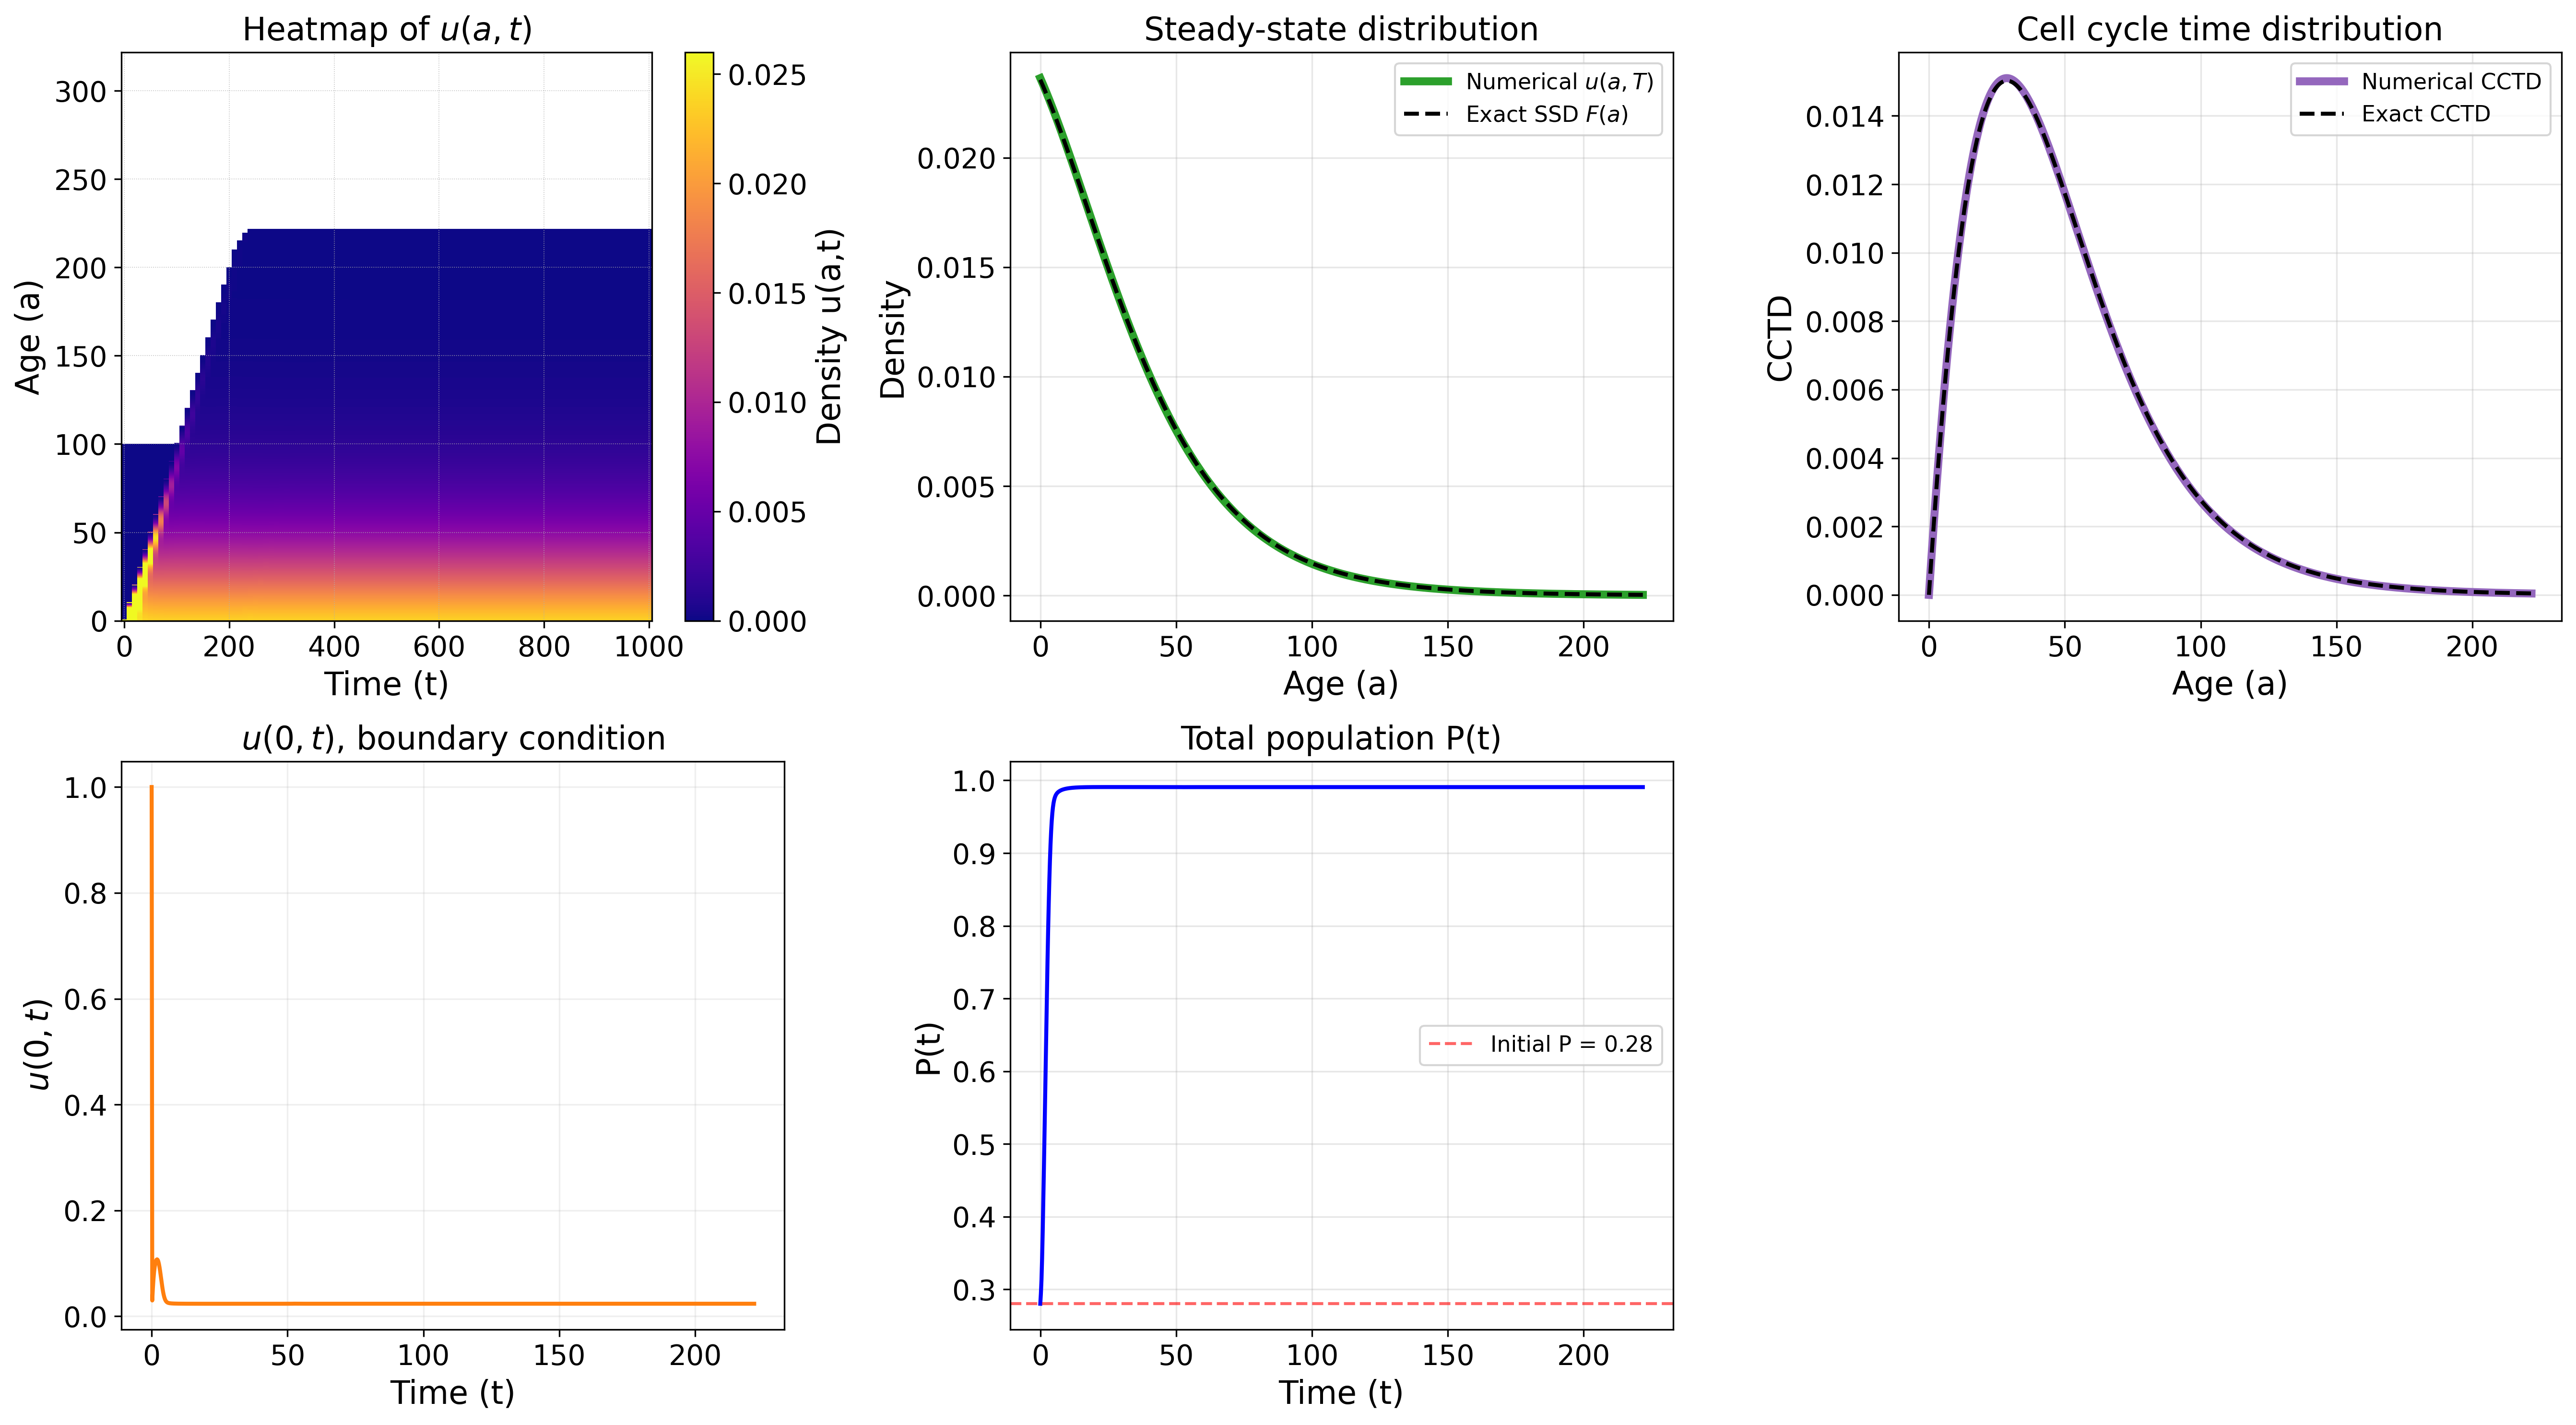

In [ ]:
# Case 4
birth_case = 3
death_case = 2
case_num = case_mapping[(death_case, birth_case)]
save_every = 100

params = { 'alpha': 0.01, 'mu0': 0.012, 'b0': 0.065, 'a_max': 100, 'da': 1e-2, 'T': 1000}
params['gamma'] = 1 # unused in this case

# Run model until steady state
model = NoDiffusionSolver(**params, birth_case=birth_case, death_case=death_case)
a_list, u_list, u0_list, P_list, C_list, D_list = model.solve(
        save_every=save_every,
        steady_state_tol=1e-6, 
        extend_after_ss=100.0,
    )
print(f"Final population: (case {birth_case},{death_case}): P={P_list[-1]:.3f}, C={C_list[-1]:.3f}, D={D_list[-1]:.3f}")

# Compute population statistics
beta=params['b0']
alpha=params['alpha']
mu=params['mu0']
gamma=params['gamma']
params['T'] = a_list[-1][-1]
T = params['T']

ages = model.age_grid[:len(u_list)]
mask = ages <= T
ages_plot = a_list[-1] 

# Extract population metrics
P_bar = float(P_list[-1])
mean_div_age, mean_pop_age = compute_mean_ages(beta, alpha, gamma, mu, P_bar, ages_plot, case_num, return_values=True)
print(f"Mean division age: {mean_div_age:.3f}, Mean population age: {mean_pop_age:.3f}")

# Plot
plot_solution_suite(params, a_list, u_list, u0_list, P_list, save_every, birth_case, case_num, 
                        make_steady_state_distributions, make_cctd_functions, division_rate)

# Create time list based on save_every
t_list = np.arange(len(P_list)) * params['da'] * save_every

case_data = {
    "a_list": a_list,
    "u_list": u_list,
    "u0_list": u0_list,
    "P_list": P_list,
    "C_list": C_list,
    "D_list": D_list,
    "t_list": t_list,  
    "a_final": a_list[-1],
    "u_final": u_list[-1],
    "P_bar": P_list[-1],
    "C_bar": C_list[-1],
    "D_bar": D_list[-1],
    "params": params,
    "case_num": case_num,
    "birth_case": birth_case,
    "death_case": death_case,
    "mean_div_age": mean_div_age,
    "mean_pop_age": mean_pop_age,
    "t_ss": model.t_ss,  
    "steady_state_tol": 1e-6, 
    "extend_after_ss": 100.0, 
    "save_every": save_every,  
}

save_case(case_num, case_data, outdir="saved_cases_no_diffusion")

[Non-spatial] Steady state detected at t=360.700
[Non-spatial] Continuing until t=1000.000
[Non-spatial] Complete at t=1000.000
Final population: (case 3,3): P=0.991, C=0.730, D=19.679
Mean division age: 25.025, Mean population age: 35.134


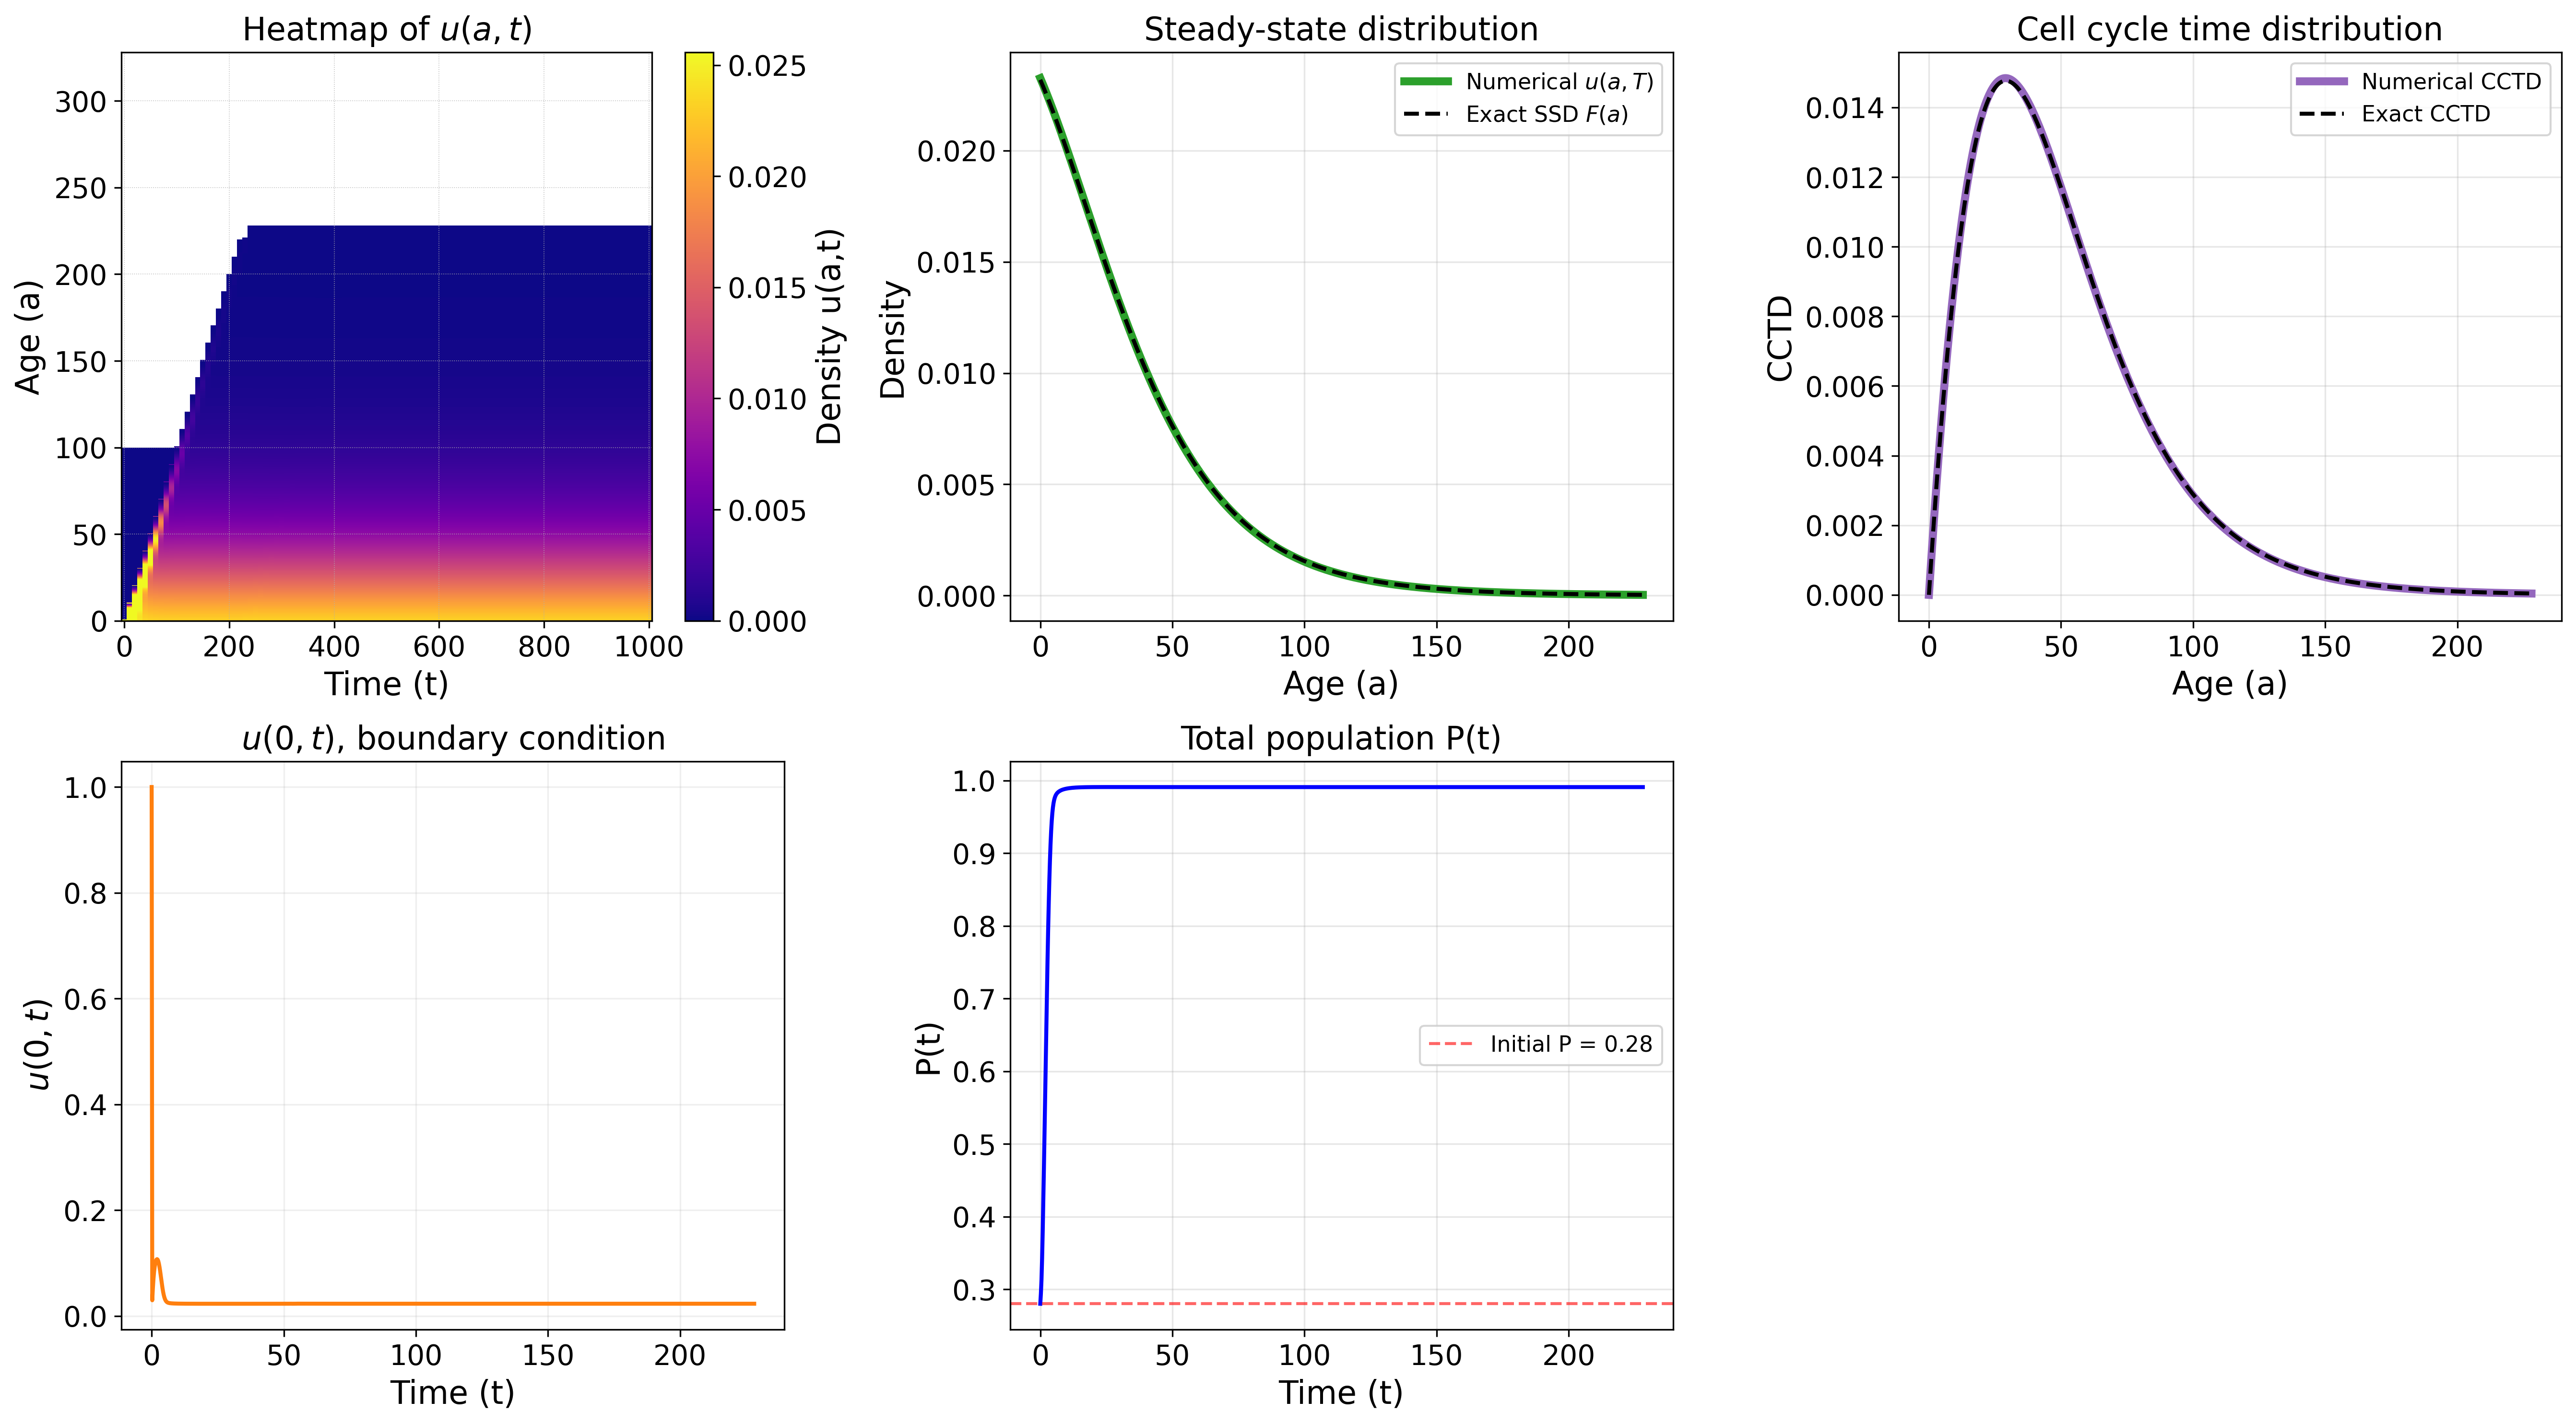

In [ ]:
# Case 5
import math

birth_case = 3
death_case = 3
case_num = case_mapping[(death_case, birth_case)]
save_every = 100

params = { 'alpha': 0.01, 'mu0': 0.012, 'b0': 0.065, 'a_max': 100, 'da': 1e-2, 'T': 1000}
params['gamma'] = 0.00001 # params['gamma'] = (params['mu0'] * (params['alpha'] * math.e)) * 0.98 # need gamma < mu0 * alpha * e for positivity of death rate

# Run model until steady state
model = NoDiffusionSolver(**params, birth_case=birth_case, death_case=death_case)
a_list, u_list, u0_list, P_list, C_list, D_list = model.solve(
        save_every=save_every,
        steady_state_tol=1e-6, 
        extend_after_ss=100.0,
    )
print(f"Final population: (case {birth_case},{death_case}): P={P_list[-1]:.3f}, C={C_list[-1]:.3f}, D={D_list[-1]:.3f}")

# Compute population statistics
beta=params['b0']
alpha=params['alpha']
mu=params['mu0']
gamma=params['gamma']
params['T'] = a_list[-1][-1]
T = params['T']

ages = model.age_grid[:len(u_list)]
mask = ages <= T
ages_plot = a_list[-1] 

# Extract population metrics
P_bar = float(P_list[-1])
mean_div_age, mean_pop_age = compute_mean_ages(beta, alpha, gamma, mu, P_bar, ages_plot, case_num, return_values=True)
print(f"Mean division age: {mean_div_age:.3f}, Mean population age: {mean_pop_age:.3f}")

# Plot
plot_solution_suite(params, a_list, u_list, u0_list, P_list, save_every, birth_case, case_num, 
                        make_steady_state_distributions, make_cctd_functions, division_rate)

# Create time list based on save_every
t_list = np.arange(len(P_list)) * params['da'] * save_every

case_data = {
    "a_list": a_list,
    "u_list": u_list,
    "u0_list": u0_list,
    "P_list": P_list,
    "C_list": C_list,
    "D_list": D_list,
    "t_list": t_list,  
    "a_final": a_list[-1],
    "u_final": u_list[-1],
    "P_bar": P_list[-1],
    "C_bar": C_list[-1],
    "D_bar": D_list[-1],
    "params": params,
    "case_num": case_num,
    "birth_case": birth_case,
    "death_case": death_case,
    "mean_div_age": mean_div_age,
    "mean_pop_age": mean_pop_age,
    "t_ss": model.t_ss,  
    "steady_state_tol": 1e-6, 
    "extend_after_ss": 100.0, 
    "save_every": save_every,  
}

save_case(case_num, case_data, outdir="saved_cases_no_diffusion")
